# Neural Network Models

## 1. Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
import sys
import os
import torch

# Add src to path
sys.path.append(os.path.abspath('..'))

from src.models import NeuralNetworkModel
from src.utils.metrics import calculate_metrics

# Set plots style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Check device
print(f"Using device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

Using device: cuda


## 2. Load Processed Data

In [2]:
train_df = pd.read_csv('../data/processed/train_featurized.csv')
test_df = pd.read_csv('../data/processed/test_featurized.csv')

X = train_df.drop(['id', 'SMILES', 'Tm'], axis=1)
y = train_df['Tm']
X_test = test_df.drop(['id', 'SMILES'], axis=1)

# Neural Networks generally require no NaNs. 
# Fill NaNs with mean (simple imputation since we did some in feature engineering)
X = X.fillna(X.mean())
X_test = X_test.fillna(X.mean())

## 3. Train Neural Network
Training MLP with 5-Fold Cross-Validation.

In [3]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

nn_params = {
    'hidden_dims': [1024, 512, 256, 128],
    'dropout_rate': 0.3,
    'learning_rate': 0.001,
    'batch_size': 64,
    'epochs': 150,
    'patience': 15
}

fold_metrics = []
test_fold_preds = []
oof_preds = np.zeros(len(X))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"\nFold {fold+1}/5")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = NeuralNetworkModel(params=nn_params)
    model.fit(X_train, y_train, X_val, y_val)
    
    val_pred = model.predict(X_val)
    oof_preds[val_idx] = val_pred
    
    metrics = calculate_metrics(y_val, val_pred)
    fold_metrics.append(metrics)
    print(f"Fold {fold+1} MAE: {metrics['MAE']:.4f}")
    
    test_fold_preds.append(model.predict(X_test))

avg_mae = np.mean([m['MAE'] for m in fold_metrics])
avg_r2 = np.mean([m['R2'] for m in fold_metrics])
print(f"\nAverage CV MAE: {avg_mae:.4f}, R2: {avg_r2:.4f}")

# Create submission
avg_preds = np.mean(test_fold_preds, axis=0)

submission = pd.DataFrame({'id': test_df['id'], 'Tm': avg_preds})
submission.to_csv('../submissions/submission_neural_net.csv', index=False)
print("Saved submission to submissions/submission_neural_net.csv")


Fold 1/5
Early stopping at epoch 101
Fold 1 MAE: 30.1081

Fold 2/5
Early stopping at epoch 56
Fold 2 MAE: 32.2655

Fold 3/5
Early stopping at epoch 61
Fold 3 MAE: 30.4121

Fold 4/5
Early stopping at epoch 58
Fold 4 MAE: 31.4458

Fold 5/5
Early stopping at epoch 91
Fold 5 MAE: 30.2688

Average CV MAE: 30.9001, R2: 0.6928
Saved submission to submissions/submission_neural_net.csv


## 4. Compare with Tree Models
If previous results are available, compare NN performance.

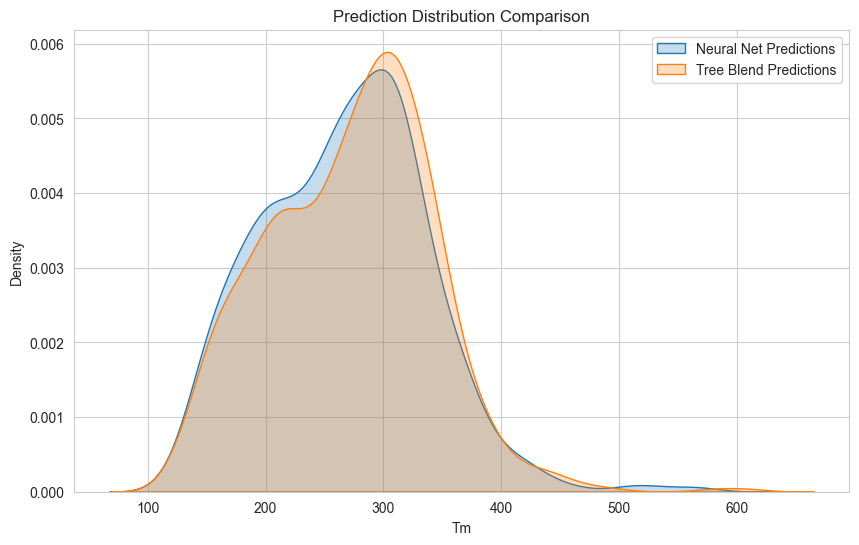

Correlation between NN and Tree Blend predictions: 0.9448


In [4]:
# Load tree blend submission if it exists to compare distribution
try:
    tree_sub = pd.read_csv('../submissions/submission_tree_blend.csv')
    
    plt.figure(figsize=(10, 6))
    sns.kdeplot(submission['Tm'], label='Neural Net Predictions', fill=True)
    sns.kdeplot(tree_sub['Tm'], label='Tree Blend Predictions', fill=True)
    plt.title('Prediction Distribution Comparison')
    plt.legend()
    plt.show()
    
    correlation = np.corrcoef(submission['Tm'], tree_sub['Tm'])[0, 1]
    print(f"Correlation between NN and Tree Blend predictions: {correlation:.4f}")
except FileNotFoundError:
    print("Tree blend submission not found for comparison.")